In [1]:
import nltk # Imports the library
nltk.download('stopwords') #Download the necessary datasets

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd

In [3]:
messages = pd.read_csv('/content/Restaurant_Reviews.tsv', sep='\t')
messages.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


## Exploratory Data Analysis

Let's check out some of the stats with some plots and the built-in methods in pandas!

In [4]:
messages.describe()

,Liked
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [5]:
messages.groupby('Liked').describe()

Review                                    
       count unique                     top freq
Liked                                           
0        500    497  The food was terrible.    2
1        500    499      I love this place.    2

In [6]:
messages['length'] = messages['Review'].apply(len)
messages.head()

,Review,Liked,length
0,Wow... Loved this place.,1,24
1,Crust is not good.,0,18
2,Not tasty and the texture was just nasty.,0,41
3,Stopped by during the late May bank holiday of...,1,87
4,The selection on the menu was great and so wer...,1,59


### Data Visualization
Let's visualize this! Let's do the imports:

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<Axes: ylabel='Frequency'>

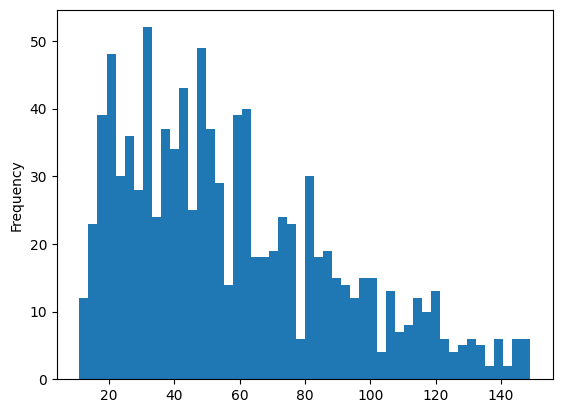

In [8]:
messages['length'].plot(bins=50, kind='hist')

In [9]:
messages.length.describe()

count    1000.000000
mean       58.315000
std        32.360052
min        11.000000
25%        33.000000
50%        51.000000
75%        80.000000
max       149.000000
Name: length, dtype: float64

In [10]:
messages[messages['length'] == 149]['Review'].iloc[0] #longest review

'The problem I have is that they charge $11.99 for a sandwich that is no bigger than a Subway sub (which offers better and more amount of vegetables).'

Looks like we have some sort of Romeo sending texts! But let's focus back on the idea of trying to see if message length is a distinguishing feature between ham and spam:

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

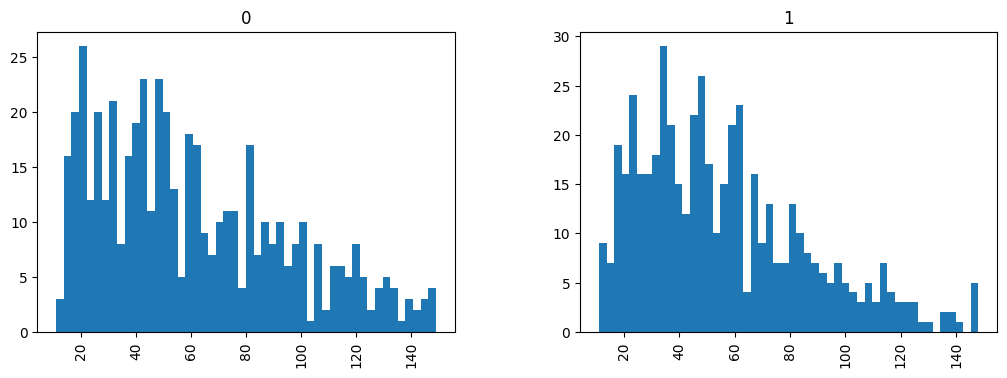

In [11]:
messages.hist(column='length', by='Liked', bins=50,figsize=(12,4))

## Text Pre-processing

In [12]:
import string
from nltk.corpus import stopwords
all_stopwords=stopwords.words('english')
all_stopwords.remove('not')
from nltk.stem.porter import PorterStemmer

In [13]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    ps=PorterStemmer()
    # Now just remove any stopwords
    return [ps.stem(word) for word in nopunc.split() if word.lower() not in set(all_stopwords)]

In [14]:
# Check to make sure its working
messages['Review'].head(5).apply(text_process)

0                                   [wow, love, place]
1                                   [crust, not, good]
2                          [not, tasti, textur, nasti]
3    [stop, late, may, bank, holiday, rick, steve, ...
4                         [select, menu, great, price]
Name: Review, dtype: object

In [15]:
# Show original dataframe
messages.head()

,Review,Liked,length
0,Wow... Loved this place.,1,24
1,Crust is not good.,0,18
2,Not tasty and the texture was just nasty.,0,41
3,Stopped by during the late May bank holiday of...,1,87
4,The selection on the menu was great and so wer...,1,59


## Vectorization

Each vector will have as many dimensions as there are unique words in the SMS corpus.  We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message.

For example:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th>
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>


Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

There are a lot of arguments and parameters that can be passed to the CountVectorizer. In this case we will just specify the **analyzer** to be our own previously defined function:

In [17]:
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['Review'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

1639


In [18]:
message4 = messages['Review'][3]
print(message4)

Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.


Now let's see its vector representation:

In [19]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 123)	1
  (0, 708)	1
  (0, 810)	1
  (0, 848)	1
  (0, 881)	1
  (0, 1171)	1
  (0, 1204)	1
  (0, 1363)	1
  (0, 1370)	1
(1, 1639)


In [20]:
print(bow_transformer.get_feature_names_out()[1363])
print(bow_transformer.get_feature_names_out()[881])

steve
may


Now we can use **.transform** on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [22]:
messages_bow = bow_transformer.transform(messages['Review'])

In [54]:
messages['Review'][:5]

0                             Wow... Loved this place.
1                                   Crust is not good.
2            Not tasty and the texture was just nasty.
3    Stopped by during the late May bank holiday of...
4    The selection on the menu was great and so wer...
Name: Review, dtype: object

In [23]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (1000, 1639)
Amount of Non-Zero occurences:  5691


In [24]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


## TF-IDF

In [25]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 1370)	0.32504109062571496
  (0, 1363)	0.3723211600542704
  (0, 1204)	0.3723211600542704
  (0, 1171)	0.2561558111760375
  (0, 881)	0.315633404218248
  (0, 848)	0.22612899750898208
  (0, 810)	0.3513993960383886
  (0, 708)	0.3723211600542704
  (0, 123)	0.3723211600542704


We'll go ahead and check what is the IDF (inverse document frequency) of the word `"good"` and of word `"food"`?

In [26]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['good']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['food']])

3.3869662022661804
3.1129642337184795


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [27]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(1000, 1639)


## Training a model

In [40]:
from sklearn.naive_bayes import MultinomialNB
like_detect_model = MultinomialNB().fit(messages_tfidf, messages['Liked'])

In [41]:
print('predicted:', like_detect_model.predict(tfidf4)[0])
print('expected:', messages.Liked[3])

predicted: 1
expected: 1



## Part 6: Model Evaluation
Now we want to determine how well our model will do overall on the entire dataset. Let's begin by getting all the predictions:

In [43]:
all_predictions = like_detect_model.predict(messages_tfidf)
print(all_predictions)

[1 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1
 0 1 0 1 0 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0
 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0
 0 1 1 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0
 0 0 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1
 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0
 0 0 0 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 0
 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1
 0 1 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 0 0 1 1
 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 1 1 1
 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0
 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 1 1 1 0 1 1 0
 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0
 1 0 1 1 1 1 0 0 1 0 1 0 

In [44]:
from sklearn.metrics import classification_report
print (classification_report(messages['Liked'], all_predictions))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       500
           1       0.97      0.95      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



In the above "evaluation",we evaluated accuracy on the same data we used for training. **You should never actually evaluate on the same dataset you train on!**

Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way. This is then our final evaluation on test data is representative of true predictive performance.

## Train Test Split

In [58]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = train_test_split(messages['Review'], messages['Liked'], test_size=0.10)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

900 100 1000


## Creating a Data Pipeline

Let's run our model again and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

In [59]:
from sklearn.pipeline import Pipeline

pipeline_1 = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Now we can directly pass message text data and the pipeline will do our pre-processing for us! We can treat it as a model/estimator API:

In [60]:
pipeline_1.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x782a0472d630>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [61]:
predictions = pipeline_1.predict(msg_test)

In [62]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86        51
           1       0.87      0.82      0.84        49

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



In [50]:
#ensemble model -xgboost, catboost
!pip -qq install catboost

In [51]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [52]:
pipeline_2 = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', CatBoostClassifier()),  # train on TF-IDF vectors w/ catboost classifier
])

In [53]:
pipeline_2.fit(msg_train,label_train)

Learning rate set to 0.009849
0:	learn: 0.6908856	total: 59.4ms	remaining: 59.4s
1:	learn: 0.6887215	total: 69.1ms	remaining: 34.5s
2:	learn: 0.6864449	total: 79.2ms	remaining: 26.3s
3:	learn: 0.6840809	total: 89.4ms	remaining: 22.3s
4:	learn: 0.6818858	total: 99.2ms	remaining: 19.7s
5:	learn: 0.6796114	total: 109ms	remaining: 18.1s
6:	learn: 0.6770593	total: 120ms	remaining: 17s
7:	learn: 0.6757621	total: 129ms	remaining: 16.1s
8:	learn: 0.6734734	total: 154ms	remaining: 17s
9:	learn: 0.6707711	total: 169ms	remaining: 16.7s
10:	learn: 0.6696479	total: 172ms	remaining: 15.5s
11:	learn: 0.6677466	total: 182ms	remaining: 15s
12:	learn: 0.6657948	total: 196ms	remaining: 14.9s
13:	learn: 0.6635764	total: 212ms	remaining: 14.9s
14:	learn: 0.6619403	total: 225ms	remaining: 14.7s
15:	learn: 0.6601838	total: 235ms	remaining: 14.4s
16:	learn: 0.6580425	total: 249ms	remaining: 14.4s
17:	learn: 0.6563151	total: 259ms	remaining: 14.1s
18:	learn: 0.6547835	total: 270ms	remaining: 13.9s
19:	learn: 0

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x782a0472d630>)),
                ('tfidf', TfidfTransformer()),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7829feab1510>)])

In [54]:
predictions = pipeline_2.predict(msg_test)

In [55]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

           0       0.80      0.77      0.79        53
           1       0.76      0.79      0.77        47

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100



In [56]:
pipeline_3 = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', XGBClassifier()),  # train on TF-IDF vectors w/ xgboost classifier
])

pipeline_3.fit(msg_train,label_train)

predictions = pipeline_3.predict(msg_test)

print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

           0       0.80      0.77      0.79        53
           1       0.76      0.79      0.77        47

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100



In [70]:
#As the naive bayes gave better accuracy than ensemble models in terms of precision, recall
#so we can save the like detection model
import pickle
pickle.dump(like_detect_model,open("food.pkl","wb"))